**Caltrans PRD Excel Extract**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.linear_model import LinearRegression

In [2]:
CA_PRD = pd.DataFrame()
for year in range(2001, 2023):
    tab = 'Table 1' if year >= 2017 else f'{year} PRD_Table 1'
    temp = pd.read_excel(pd.ExcelFile(f'HPMS2001_2022_PRD/{year}_PRD.xlsx'), tab)
    # temp = temp[temp.iloc[:, 0]=='TOTAL']
    temp = temp[temp.iloc[:, 0].isin(['TOTAL', 'STATEWIDE TOTAL'])]
    temp = temp.dropna(axis=1, how='all')
    temp.columns = ['Jurisdiction', 'Total Maintained Miles', 'Lane Miles', 'Annual VMT (Millions)']
    CA_PRD = pd.concat([CA_PRD, temp])
    # print(f'{year} successful')

In [3]:
def hwymiles(county):
    TAB5_PRD = pd.DataFrame()
    for year in range(2001, 2023):
        tab = 'Table 5' if year >= 2017 else f'{year} PRD_Table 5'
        temp = pd.read_excel(pd.ExcelFile(f'HPMS2001_2022_PRD/{year}_PRD.xlsx'), tab)
        temp = temp.dropna(axis=1, how='all')
        temp = temp[temp.iloc[:, 0]==f'{county}']
        temp.columns = ['County', 'City Roads', 'County Roads', 'State Highway', 'Federal Agencies', 
                        'Other State Agencies', 'Other Local Agencies', 'Other Agencies', 'Total']
        temp['Year'] = year
        TAB5_PRD = pd.concat([TAB5_PRD, temp])

    TAB5_PRD.reset_index(drop=True, inplace=True)
    TAB5_PRD['Year'] = np.arange(2001, 2023)

    return TAB5_PRD

def VMT(county):
    TAB6_PRD = pd.DataFrame()
    for year in range(2001, 2023):
        try:
            tab = 'Table 6' if year >= 2017 else f'{year} PRD_Table 6'
            temp = pd.read_excel(pd.ExcelFile(f'HPMS2001_2022_PRD/{year}_PRD.xlsx'), tab)
        except ValueError:
            temp = pd.DataFrame([[np.nan]*8], columns=['County', 'NA', 'Rural Miles', 'Urban Miles', 'Total Miles', 'Rural DVMT', 'Urban DVMT', 'Total DVMT'])
            temp['Year'] = year
            TAB6_PRD = pd.concat([TAB6_PRD, temp])
            continue
        except Exception as e:
            continue

        temp = temp.dropna(axis=1, how='all')
        temp = temp[temp.iloc[:, 0].str.contains(f"^{re.escape(county)}\s+TOTAL$", case=False, na=False)]
        # temp = temp[temp.iloc[:, 0] == 'ALAMEDA STATE HIGHWAY'] # Either this or the code above needs to be commented out
        # temp = temp[temp.iloc[:, 0] == 'ALAMEDA CITIES'] # Either this or the code above needs to be commented out
        temp.columns = ['County', 'NA', 'Rural Miles', 'Urban Miles', 'Total Miles', 'Rural DVMT', 'Urban DVMT', 'Total DVMT']
        temp['Year'] = year
        TAB6_PRD = pd.concat([TAB6_PRD, temp])

    TAB6_PRD.reset_index(drop=True, inplace=True)

    # value_2007 = TAB6_PRD.loc[(TAB6_PRD['Year'] == 2007), 'Total DVMT'].values[0]
    # value_2010 = TAB6_PRD.loc[(TAB6_PRD['Year'] == 2010), 'Total DVMT'].values[0]
    # value_2008 = value_2007 + (value_2010 - value_2007) / 3
    # value_2009 = value_2007 + 2 * (value_2010 - value_2007) / 3

    # TAB6_PRD.loc[(TAB6_PRD['Year'] == 2008), 'Total DVMT'] = value_2008
    # TAB6_PRD.loc[(TAB6_PRD['Year'] == 2009), 'Total DVMT'] = value_2009

    return TAB6_PRD

In [ ]:
def rolling_median(data, window_size):
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd.")
    
    half_window = window_size // 2
    padded_data = np.pad(data, (half_window, half_window), mode='reflect')
    rolling_medians = np.array([np.median(padded_data[i:i+window_size]) for i in range(len(data))])
    
    return rolling_medians

In [1]:
func = pd.read_excel('FUNC.xlsx', sheet_name="2001")
func.set_index('County', inplace=True)
func.fillna(0, inplace=True)

def safe_log(x):
    return np.where(x > 0, np.log(x), 0)
# FC = "OTHER FWY & EXP"

# func_df = func.filter(like = "TOTAL").values - func.filter(like = "LOCAL").values - (func.filter(regex='INTERSTATE').values + func.filter(regex='OTHER FWY & EXP').values)
# func_df = func.filter(like = FC).values
func_df = func.filter(regex='TOTAL')

i = 0

county_name = func.index[i]

df = pd.DataFrame({
    "Years": list(range(2001, 2023)),
    f"{county_name} Lane Miles": func_df.iloc[i].values,
    "func class %": func_df.iloc[i].values / func.filter(like='TOTAL').iloc[i].values
})

plt.plot(df['Years'], df[f"{county_name} Lane Miles"])
plt.plot(df['Years'], rolling_median(df[f"{county_name} Lane Miles"], 11))
plt.title(f'{county_name} Lane Miles')
plt.ylabel('Lane Miles')
plt.show()

df['rolling'] = rolling_median(df[f"{county_name} Lane Miles"], 11)
# df[f"{county_name} Lane Miles Lagged"] = df[f"rolling"].shift(1)
# df.dropna().reset_index(drop=True)

data = pd.read_excel('/Users/joelt/datahere/ca_county.xlsx')
file_name = data[data['County'] == county_name.upper()]['FileName'].reset_index(drop=True)[0]
df[f'{county_name} Pop'] = pd.read_excel(f'~/datahere/cty_pop/{file_name}.xls').iloc[41:63]['Unnamed: 1'].reset_index(drop=True)
FIPS_Code = str(data[data['County'] == county_name.upper()]['FIPS Code'].reset_index(drop=True)[0]).zfill(3)
df[f'{county_name} Income'] = pd.read_excel('/Users/joelt/datahere/personal_income/Data.xls', sheet_name='Annual').iloc[32:55][f'PCPI06{FIPS_Code}'].reset_index(drop=True)

df[f'{county_name} VMT'] = rolling_median(VMT(f'{county_name}')['Total DVMT'], 3)

plt.plot(df['Years'], VMT(f'{county_name}')['Total DVMT'])
plt.plot(df['Years'], rolling_median(VMT(f'{county_name}')['Total DVMT'], 3))
plt.title(f'{county_name} VMT')
plt.ylabel('Lane Miles')
plt.show()

# plt.plot(df['Years'], df['func class %'])
# # plt.plot(df['Years'], rolling_median(VMT(f'{county_name}')['Total DVMT'], 3))
# # plt.title(f'{county_name} VMT')
# plt.ylabel('% of total')
# plt.show()

X = df[['rolling', f'{county_name} Pop', f'{county_name} Income', 'func class %']].applymap(safe_log)
# X = df[[f'{county_name} Lane Miles Lagged', f'{county_name} Pop', f'{county_name} Income']].applymap(safe_log)
Y = np.log(df[f'{county_name} VMT'].astype(float))

model = LinearRegression()
model.fit(X, Y)
# r2 = round(model.score(X, Y), 5)


# plt.figure(figsize=(10,5))
plt.plot(df['Years'], Y, label = 'Reported VMT')
plt.plot(df['Years'], model.predict(X), label = 'Predicted VMT')
plt.legend()
plt.show()

NameError: name 'pd' is not defined

In [7]:
func = pd.read_excel('FUNC.xlsx', sheet_name="2001")
func.set_index('County', inplace=True)
func.fillna(0, inplace=True)

vmt_data = {county: rolling_median(VMT(county)['Total DVMT'], 3) for county in func.index}

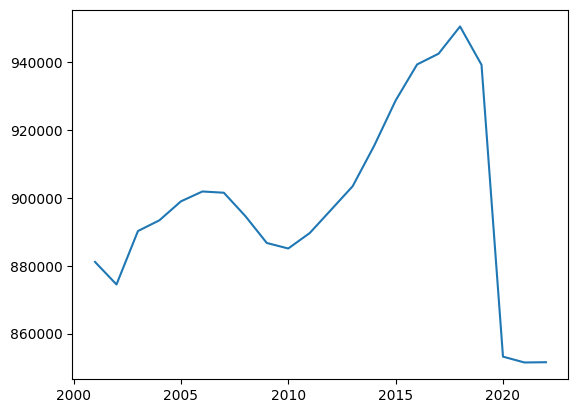

In [8]:
plt.plot(df['Years'], np.sum(list(vmt_data.values()), axis=0))

In [21]:
years_range = list(range(2001, 2023))

ca_county_codes = pd.read_excel('~/datahere/ca_county.xlsx')
income_data = pd.read_excel('~/datahere/personal_income/Data.xls', sheet_name='Annual')
unemployment = pd.read_excel(f'~/datahere/unemployment/unemployment.xls', sheet_name = 'Annual')

def safe_log(x):
    return np.where(x > 0, np.log(x), 0)

def function(FC, vmt_data):

    data_list = []
    func_df = func.filter(like=FC)

    for i, county_name in enumerate(func.index):
        lane_miles = func_df.iloc[i].values
        df = pd.DataFrame({
            "Years": list(range(2001, 2023)),
            f"{county_name} Lane Miles": lane_miles,
            "func class %": lane_miles / func.filter(like='TOTAL').iloc[i].values
        })

        df['rolling'] = rolling_median(df[f"{county_name} Lane Miles"], 11)
        file_name = ca_county_codes[ca_county_codes['County'] == county_name.upper()]['FileName'].reset_index(drop=True)[0]
        
        # Add Population and Income data
        df[f'{county_name} Pop'] = pd.read_excel(f'~/datahere/cty_pop/{file_name}.xls').iloc[41:63]['Unnamed: 1'].reset_index(drop=True)
        FIPS_Code = str(ca_county_codes[ca_county_codes['County'] == county_name.upper()]['FIPS Code'].reset_index(drop=True)[0]).zfill(3)
        df[f'{county_name} Income'] = income_data.iloc[32:55][f'PCPI06{FIPS_Code}'].reset_index(drop=True)
        df[f'{county_name} Unemployment'] = unemployment.iloc[11:34][f'LAUCN06{FIPS_Code}0000000003A']

        # Use precomputed VMT data
        df[f'{county_name} VMT'] = vmt_data[county_name]
 
        X = df[[f'rolling', f'{county_name} Pop', f'{county_name} Income']].applymap(safe_log)
        Y = np.log(df[f'{county_name} VMT'].astype(float))

        model = LinearRegression()
        model.fit(X, Y)
        r2 = round(model.score(X, Y), 5)

        change = df[-1:][f'{county_name} Lane Miles'].iloc[0] - df[:1][f'{county_name} Lane Miles'].iloc[0]
        func_change = df[-1:]["func class %"].iloc[0] - df[:1][f"func class %"].iloc[0]

        data_list.append({
            'County': county_name.capitalize(),
            # 'FC': FC,
            'lane_coef': model.coef_[0],
            'pop_coef': model.coef_[1],
            'income_coef': model.coef_[2],
            # 'unemployment_coef': model.coef_[3],
            'r^2': r2,
            'func_class_%': round(np.median(df['func class %']), 2),
            'lane_mile_growth': round((change / df[:1][f'{county_name} Lane Miles'].iloc[0]) if change != 0 else 0, 2),
            # 'func_class_%_growth': round((func_change / df[:1]["func class %"].iloc[0]) if func_change != 0 else 0, 2),
            'func_class_%_growth': round(func_change, 2)
        })
        # plt.figure(figsize=(4,2))
        # plt.plot(df['Years'], df[f"{county_name} Lane Miles"])
        # plt.plot(df['Years'], df['rolling'])
        # plt.title(f'{county_name} {FC} Lane Miles')
        # plt.ylabel('Lane Miles')
        # plt.show()

        # plt.figure(figsize=(4,2))
        # plt.plot(df['Years'], Y, label = 'Reported VMT')
        # plt.plot(df['Years'], model.predict(X), label = 'Predicted VMT')
        # plt.legend()
        # plt.title(f'{county_name} {FC} VMT')
        # plt.show()

    return pd.DataFrame(data_list)

results = {}
for FC in ['INTERSTATE', 'OTHER FWY & EXP', 'OTHER PRINCIPAL ARTERIAL', 'MINOR ARTERIAL', 'MAJOR COLLECTOR', 'MINOR COLLECTOR', 'LOCAL', 'TOTAL']:
    results[FC] = function(FC, vmt_data)

/var/folders/yl/_fjnz6h53yv8g0p40zrwgxsc0000gn/T/ipykernel_8049/4091671635.py:8: RuntimeWarning: divide by zero encountered in log
  return np.where(x > 0, np.log(x), 0)
/var/folders/yl/_fjnz6h53yv8g0p40zrwgxsc0000gn/T/ipykernel_8049/4091671635.py:8: RuntimeWarning: divide by zero encountered in log
  return np.where(x > 0, np.log(x), 0)
/var/folders/yl/_fjnz6h53yv8g0p40zrwgxsc0000gn/T/ipykernel_8049/4091671635.py:8: RuntimeWarning: divide by zero encountered in log
  return np.where(x > 0, np.log(x), 0)
/var/folders/yl/_fjnz6h53yv8g0p40zrwgxsc0000gn/T/ipykernel_8049/4091671635.py:8: RuntimeWarning: divide by zero encountered in log
  return np.where(x > 0, np.log(x), 0)
/var/folders/yl/_fjnz6h53yv8g0p40zrwgxsc0000gn/T/ipykernel_8049/4091671635.py:8: RuntimeWarning: divide by zero encountered in log
  return np.where(x > 0, np.log(x), 0)
/var/folders/yl/_fjnz6h53yv8g0p40zrwgxsc0000gn/T/ipykernel_8049/4091671635.py:8: RuntimeWarning: divide by zero encountered in log
  return np.where(x

In [19]:
pd.set_option('display.expand_frame_repr', False)
for i in range(58):
    print(pd.concat(
        [results[FC].iloc[i].to_frame().T.assign(FC=FC) for FC in ['INTERSTATE', 'OTHER FWY & EXP', 'OTHER PRINCIPAL ARTERIAL', 'MINOR ARTERIAL', 'MAJOR COLLECTOR', 'MINOR COLLECTOR', 'LOCAL', 'TOTAL']],
        ignore_index=True
    ))

    County lane_coef  pop_coef income_coef      r^2 func_class_% lane_mile_growth func_class_%_growth                        FC
0  Alameda  0.397743  1.976914   -0.303555  0.48077         0.09             -0.1               -0.02                INTERSTATE
1  Alameda   0.15974  1.404296    -0.31751  0.44227         0.01             0.18                 0.0           OTHER FWY & EXP
2  Alameda -1.167527  0.990169   -0.335161  0.53918          0.1             0.33                0.02  OTHER PRINCIPAL ARTERIAL
3  Alameda -0.963755  1.294859   -0.273575  0.49145         0.12              0.1                -0.0            MINOR ARTERIAL
4  Alameda -0.796322    1.3267   -0.273558   0.4429         0.12             0.02               -0.01           MAJOR COLLECTOR
5  Alameda  0.029689  1.400941   -0.308574  0.44404          0.0              1.2                 0.0           MINOR COLLECTOR
6  Alameda  1.603307   0.45086   -0.276562  0.54564         0.55             0.12                0.01   

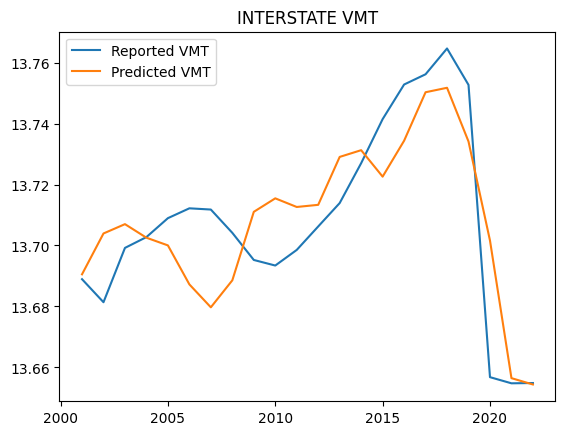

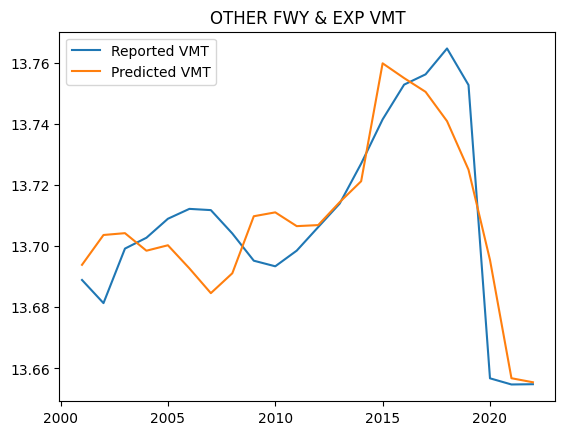

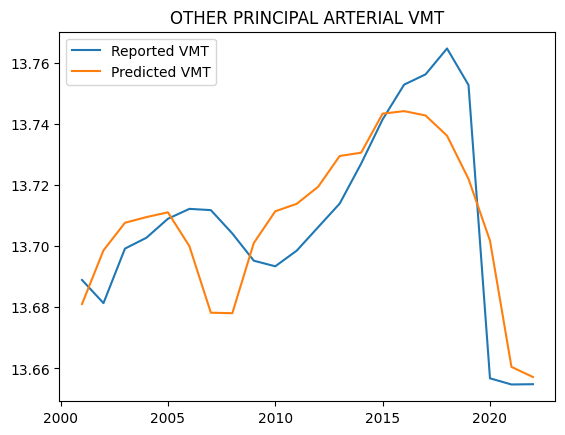

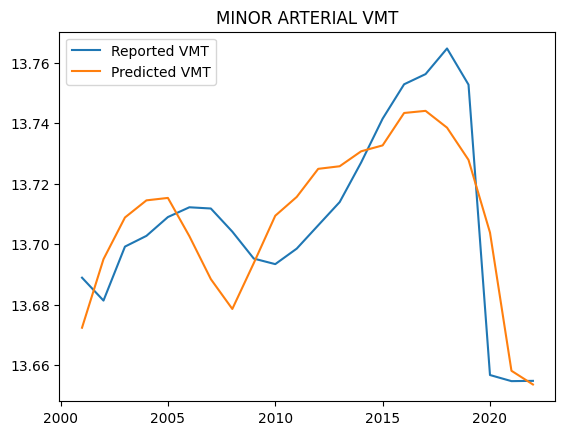

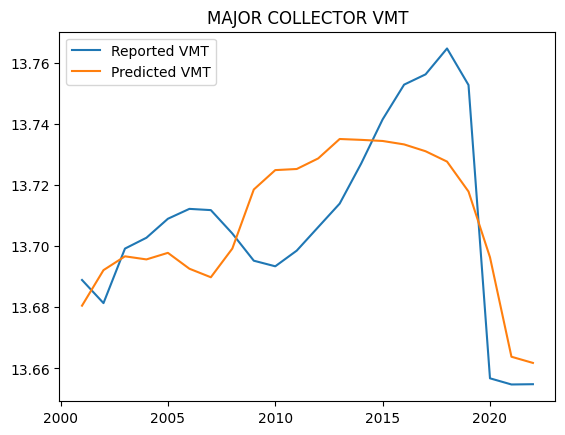

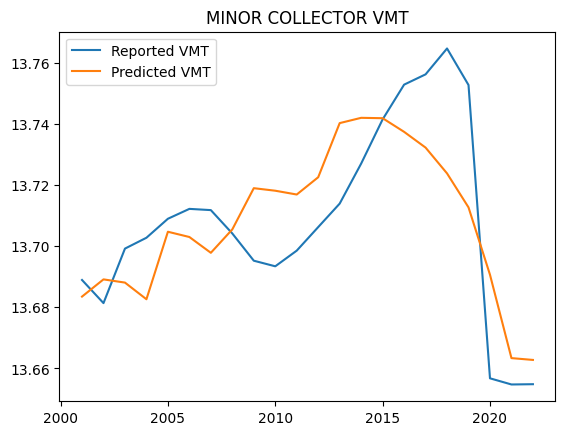

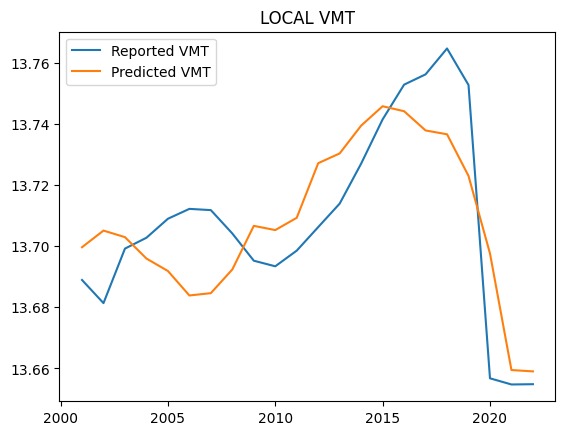

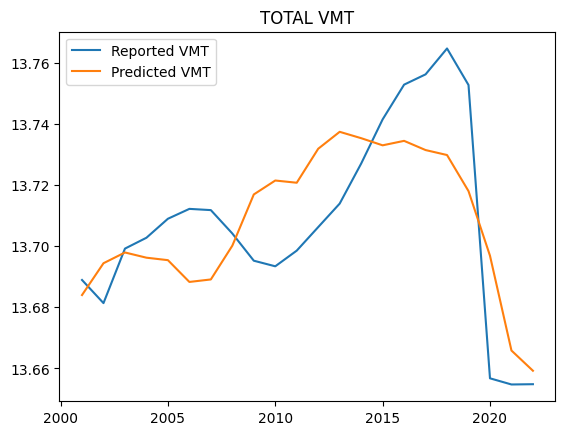

In [13]:
def calculate_total_series(data_dict, keys):
    return sum(data_dict[key] for key in keys)

total_vmt = calculate_total_series(vmt_data, vmt_data.keys())
total_population = calculate_total_series({county: pd.read_excel(f'~/datahere/cty_pop/{file_name}.xls').iloc[41:63]['Unnamed: 1'].values 
                                           for county, file_name in ca_county_codes.set_index('County')['FileName'].items()}, ca_county_codes['County'].str.upper())
total_income = calculate_total_series({county: income_data.iloc[32:55][f'PCPI06{str(fips).zfill(3)}'].values 
                                       for county, fips in ca_county_codes.set_index('County')['FIPS Code'].items()}, ca_county_codes['County'].str.upper())

def total_function(FC, total_vmt, total_population, total_income):
    data_list = []

    func_df = func.filter(like=FC)

    df = pd.DataFrame({
        "Years": list(range(2001, 2023)),
        "Total Lane Miles": func_df.sum(axis=0).values,  # Summing over counties for each year
        "Total Pop": total_population,
        "Total Income": total_income,
        "Total VMT": total_vmt
    })

    df['rolling'] = rolling_median(df[f"Total Lane Miles"], 11)
    
    # Log transformation for regression
    X = df[['rolling', 'Total Pop', 'Total Income']].applymap(safe_log)
    Y = safe_log(df['Total VMT'])

    model = LinearRegression()
    model.fit(X, Y)
    r2 = round(model.score(X, Y), 5)

    change = df[-1:]['Total Lane Miles'].iloc[0] - df[:1]['Total Lane Miles'].iloc[0]

    data_list.append({
        'FC': FC,
        'lane_coef': model.coef_[0],
        'pop_coef': model.coef_[1],
        'income_coef': model.coef_[2],
        'r^2': r2,
        # 'func_class_%': round(np.mean(df['func class %']), 2),
        'lane_mile_growth': round((change / df[:1]['Total Lane Miles'].iloc[0]) if change != 0 else 0, 2)

    })

    # plt.figure(figsize=(4,2))
    plt.plot(df['Years'], Y, label = 'Reported VMT')
    plt.plot(df['Years'], model.predict(X), label = 'Predicted VMT')
    plt.legend()
    plt.title(f'{FC} VMT')
    plt.show()

    return pd.DataFrame(data_list)

# Generate results for all function classes, including TOTAL
total_results = {}
for FC in ['INTERSTATE', 'OTHER FWY & EXP', 'OTHER PRINCIPAL ARTERIAL', 'MINOR ARTERIAL', 'MAJOR COLLECTOR', 'MINOR COLLECTOR', 'LOCAL', 'TOTAL']:
    total_results[FC] = total_function(FC, total_vmt, total_population, total_income)


In [14]:
print(pd.concat(total_results[FC] for FC in ['INTERSTATE', 'OTHER FWY & EXP', 'OTHER PRINCIPAL ARTERIAL', 'MINOR ARTERIAL', 'MAJOR COLLECTOR', 'MINOR COLLECTOR', 'LOCAL', 'TOTAL']))

                         FC  lane_coef  pop_coef  income_coef      r^2  lane_mile_growth
0                INTERSTATE   1.986212  1.513623    -0.371474  0.66535              0.05
0           OTHER FWY & EXP   0.330907  1.154333    -0.333487  0.72634              0.38
0  OTHER PRINCIPAL ARTERIAL  -1.208293  1.820396    -0.292472  0.64146              0.06
0            MINOR ARTERIAL  -1.268526  2.279491    -0.294807  0.67115              0.08
0           MAJOR COLLECTOR   0.236158  1.252452    -0.250124  0.53124              0.13
0           MINOR COLLECTOR  -1.074308  0.710585    -0.246216  0.57306             -0.06
0                     LOCAL   1.743236  0.723388    -0.281784  0.63084              0.14
0                     TOTAL   0.518292  1.138227    -0.244239  0.53679              0.12
